<a href="https://colab.research.google.com/github/baharehbehrouz/DL/blob/class/3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2024-11-28 12:55:27--  https://raw.githubusercontent.com/Alireza-Akhavan/SRU-deeplearning-workshop/master/dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 917 [text/plain]
Saving to: ‘dataset.py.3’

dataset.py.3        100%[===================>]     917  --.-KB/s    in 0s      

2024-11-28 12:55:27 (3.87 MB/s) - ‘dataset.py.3’ saved [917/917]

mkdir: cannot create directory ‘dataset’: File exists
--2024-11-28 12:55:27--  https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/raw/master/dataset/Data_hoda_full.mat
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/Alireza-Akhavan/deepl

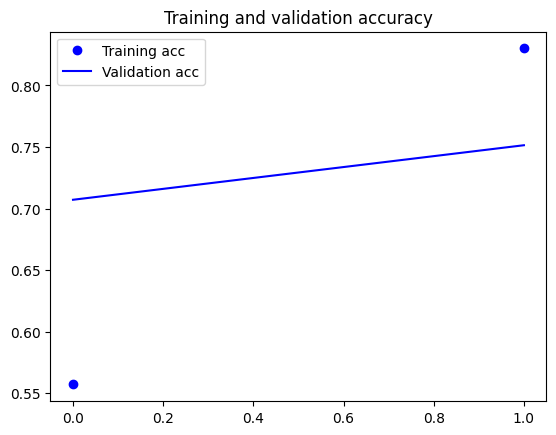

In [4]:
# 1. Download the required dataset and helper script
!wget https://raw.githubusercontent.com/Alireza-Akhavan/SRU-deeplearning-workshop/master/dataset.py
!mkdir dataset
!wget https://github.com/Alireza-Akhavan/SRU-deeplearning-workshop/raw/master/dataset/Data_hoda_full.mat -P dataset

# 2. Import libraries and modules
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import Callback, TensorBoard
import numpy as np
from dataset import load_hoda
import datetime
import matplotlib.pyplot as plt

# 3. Load pre-shuffled HODA data into train and test sets
X_train, y_train, X_test, y_test = load_hoda(
    training_sample_size=3500,
    test_sample_size=400,
    size=28
)

# 4. Preprocess input data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

# Reshape to (n x 28 x 28 x 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# 5. Define model architecture
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# 6. Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

# 7. Define a custom callback to stop training when accuracy reaches 75%
class StopAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Check training and validation accuracy
        train_accuracy = logs.get('sparse_categorical_accuracy')
        val_accuracy = logs.get('val_sparse_categorical_accuracy')

        if train_accuracy >= self.target_accuracy or val_accuracy >= self.target_accuracy:
            print(f"\nStopping training: Accuracy reached {self.target_accuracy*100}%!")
            self.model.stop_training = True

# 8. Create an instance of the custom callback with 75% accuracy threshold
stop_callback = StopAtAccuracy(target_accuracy=0.75)

# 9. Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# 10. Fit model on training data with callbacks
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=256,
    validation_split=0.2,
    callbacks=[tensorboard_callback, stop_callback]
)

# 11. Plot training and validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
